# A temperature forecasting problem

In [3]:
import os

data_dir = '/Users/ajn/Downloads/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


This outputs a count of 420,551 lines of data (each line is a timestep: a record of a date and 14 weather-related values)

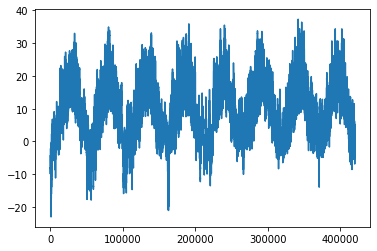

In [5]:
# Let's convert all of these 420,551 lines of data into a Numpy array:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
# For instance, here is the plot of temperature (in degrees Celsius) over time:
import matplotlib.pyplot as plt

temp = float_data[:, 1] # temperature in degrees celcius
plt.plot(range(len(temp)), temp)
plt.show()

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points per day):

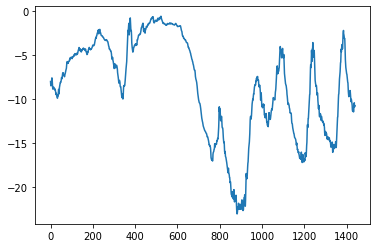

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

On this plot, we can see daily periodicity, especially evident for the last 4 days.

# Preparing the data
We will use the following parameter values:

1. lookback = 720, i.e. our observations will go back 5 days.
2. steps = 6, i.e. our observations will be sampled at one data point per hour.
3. delay = 144, i.e. our targets will be 24 hours in the future.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Now here is the data generator that we will use. It yields a tuple (samples, targets) where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
500/500 [==============================] - 117s 234ms/step - loss: 0.3033 - val_loss: 0.1649
Epoch 2/5
500/500 [==============================] - 115s 231ms/step - loss: 0.2698 - val_loss: 0.1176
Epoch 3/5
500/500 [==============================] - 115s 229ms/step - loss: 0.2603 - val_loss: 0.1223
Epoch 4/5
500/500 [==============================] - 138s 276ms/step - loss: 0.2518 - val_loss: 0.1410
Epoch 5/5
500/500 [==============================] - 147s 294ms/step - loss: 0.2445 - val_loss: 0.1106


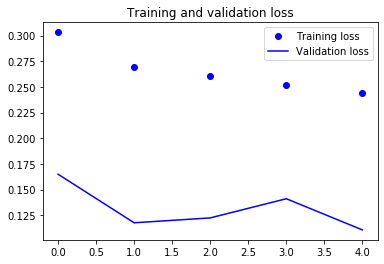

In [17]:
# Let look at our results:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
history1 = model.fit_generator(test_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_steps=test_steps)

Epoch 1/5
500/500 [==============================] - 81s 161ms/step - loss: 0.2977
Epoch 2/5
500/500 [==============================] - 82s 165ms/step - loss: 0.2734
Epoch 3/5
500/500 [==============================] - 80s 161ms/step - loss: 0.2879
Epoch 4/5
500/500 [==============================] - 77s 155ms/step - loss: 0.2520
Epoch 5/5
500/500 [==============================] - 81s 161ms/step - loss: 0.2818


In [35]:
celsius_mae = 0.28 * std[1]
print('Celsius MAE:', celsius_mae)

Celsius MAE: 2.4786997430172937


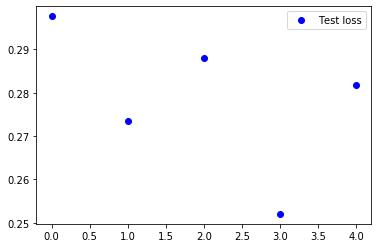

In [33]:
loss = history1.history['loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Test loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________
